In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

In [10]:
# Dataset available at https://data.cityofnewyork.us/City-Government/Good-Food-Purchasing-Data/usrf-za7k
path = 'Good_Food_Purchasing_Data.csv'
df= pd.read_csv(path)

In [11]:
# Dropping rows with NaN values in any of the specified columns
df = df.dropna(subset=['# of Units', 'Total Weight in lbs', 'Total Cost'])
df[(df["Total Cost"].isna()) | (df["# of Units"].isna()) | (df["Total Weight in lbs"].isna())]

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,# of Units,Total Weight in lbs,Total Cost


In [12]:
# Set Total Cost and Total Weight in lbs to 0 where # of Units = 0
df.loc[df["# of Units"] == 0, ["Total Cost"]] = 0
df

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,# of Units,Total Weight in lbs,Total Cost
0,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 2 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,40.0,100.0,560.0
1,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 3 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,40.0,106.0,600.0
2,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, formula","Premium Nursette Ready-to-Feed Infant Formula,...",Enfamil,Babylab Inc.,Babylab Inc.,200.0,1200.0,16200.0
3,Administration for Childrens Services,2018-2019,Beverages,Beverages,"juice, fruit punch, ss","100% Juice Variety Pack, 4 fl oz bottles",Enfamil,Babylab Inc.,Babylab Inc.,100.0,600.0,1940.0
4,Administration for Childrens Services,2018-2019,Condiments & Snacks,Condiments & Snacks,"cereal, baby, oatmeal",Single Grain Oatmeal Baby Cereal,Enfamil,Babylab Inc.,Babylab Inc.,10.0,60.0,290.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17203,Department of Education,2020-2021,Produce,Vegetables,"vegetable, blend, frozen, commodity",Veg Mixed Vegetable No Salt Added Frzn USDA (VO),"NA, NA",NaN,NaN,9239.0,0.0,49463.0
17204,Department of Education,2020-2021,Seafood,Seafood,"fish, patty, breaded",Fish Breaded Patty,"NA, New Hampshire",NaN,NaN,7316.0,0.0,164246.0
17205,Department of Education,2020-2021,Seafood,Seafood,"tuna, light, canned",Fish Tuna Light Can,"Golbon, NA",FoodCo,FoodCo,1978.0,49450.0,130101.0
17206,Department of Education,2020-2021,Seafood,Seafood,"tuna, light, canned",Fish Tuna Light Can,"Golbon, NA",Teri Nichols,Teri Nichols,2903.0,72575.0,167341.0


In [13]:
filtered_df = df.iloc[:, 9:12]
categorical_df = df.iloc[:, 0:9]

categorical_df["Total Cost"] = df["Total Cost"]
categorical_df

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,Total Cost
0,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 2 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,560.0
1,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 3 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,600.0
2,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, formula","Premium Nursette Ready-to-Feed Infant Formula,...",Enfamil,Babylab Inc.,Babylab Inc.,16200.0
3,Administration for Childrens Services,2018-2019,Beverages,Beverages,"juice, fruit punch, ss","100% Juice Variety Pack, 4 fl oz bottles",Enfamil,Babylab Inc.,Babylab Inc.,1940.0
4,Administration for Childrens Services,2018-2019,Condiments & Snacks,Condiments & Snacks,"cereal, baby, oatmeal",Single Grain Oatmeal Baby Cereal,Enfamil,Babylab Inc.,Babylab Inc.,290.0
...,...,...,...,...,...,...,...,...,...,...
17203,Department of Education,2020-2021,Produce,Vegetables,"vegetable, blend, frozen, commodity",Veg Mixed Vegetable No Salt Added Frzn USDA (VO),"NA, NA",NaN,NaN,49463.0
17204,Department of Education,2020-2021,Seafood,Seafood,"fish, patty, breaded",Fish Breaded Patty,"NA, New Hampshire",NaN,NaN,164246.0
17205,Department of Education,2020-2021,Seafood,Seafood,"tuna, light, canned",Fish Tuna Light Can,"Golbon, NA",FoodCo,FoodCo,130101.0
17206,Department of Education,2020-2021,Seafood,Seafood,"tuna, light, canned",Fish Tuna Light Can,"Golbon, NA",Teri Nichols,Teri Nichols,167341.0


In [14]:
# Step 2: Explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3751 entries, 0 to 17207
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Agency                 3751 non-null   object 
 1   Time Period            3751 non-null   object 
 2   Food Product Group     3751 non-null   object 
 3   Food Product Category  3751 non-null   object 
 4   Product Name           3750 non-null   object 
 5   Product Type           3751 non-null   object 
 6   Origin Detail          3625 non-null   object 
 7   Distributor            2856 non-null   object 
 8   Vendor                 3269 non-null   object 
 9   # of Units             3751 non-null   float64
 10  Total Weight in lbs    3751 non-null   float64
 11  Total Cost             3751 non-null   float64
dtypes: float64(3), object(9)
memory usage: 381.0+ KB


In [15]:
df.describe()

,# of Units,Total Weight in lbs,Total Cost
count,3.751000e+03,3.751000e+03,3.751000e+03
mean,8.212765e+04,1.129059e+05,1.404233e+05
std,1.276676e+06,6.780194e+05,4.251303e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.015000e+02,3.500000e+02,1.215000e+03
50%,9.850000e+02,6.100000e+03,1.574200e+04
75%,5.588500e+03,5.579600e+04,9.397900e+04
max,5.050947e+07,2.525474e+07,9.110741e+06


<Axes: >

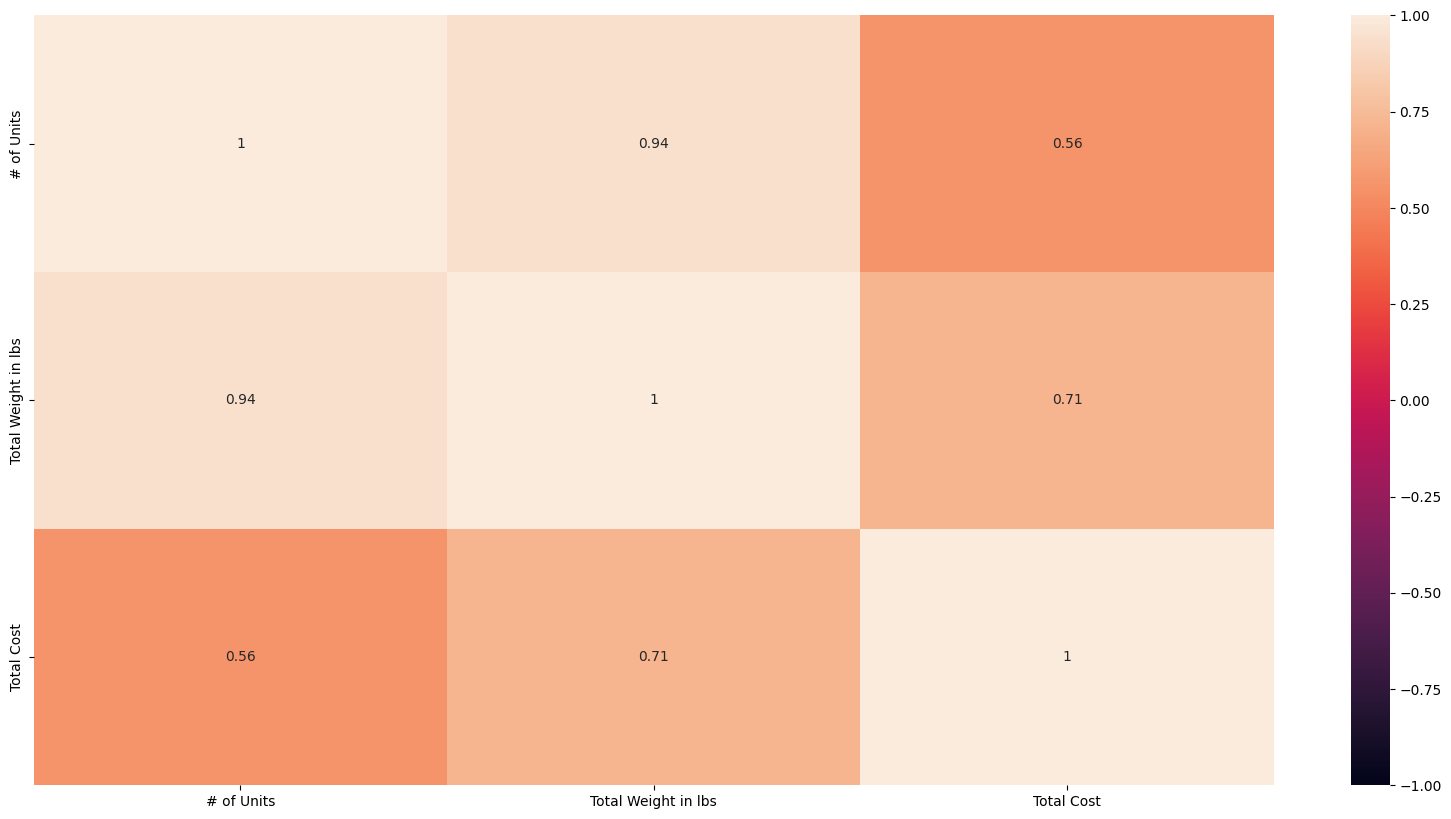

In [16]:
import matplotlib.colors as clr
# correlation matrix
myColors = ("red","white","blue")
cmap1 = clr.LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
corr = filtered_df.corr()
mask = np.zeros_like(corr, dtype=bool)
#mask[np.triu_indices_from(mask)]= True
plt.figure(figsize=(20,10))
sns.heatmap(corr, mask = mask, vmin = -1, vmax = 1, annot=True)

In [ ]:
# Let Target be Total_cost
x_vars = ["# of Units", "Total Weight in lbs"]
y_vars = ["Total Cost"]
sns.pairplot(filtered_df, x_vars=x_vars, y_vars=y_vars)

In [ ]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Food Product Category", data=categorical_df)

In [ ]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot(x="Total Cost", y="Vendor", data=categorical_df)

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Time Period", data=categorical_df)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,600))  # Adjust the figure size as needed
sns.barplot(data=categorical_df, hue="Time Period", x="Total Cost", y="Product Name", orient="h")
plt.tight_layout()

In [ ]:
sns.boxplot( x="Total Cost", y="Food Product Group", data=categorical_df)

In [ ]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Distributor", data=categorical_df)
plt.tight_layout()  # Adjust layout for better visibility

In [ ]:
sns.boxplot( x="Total Cost", y="Agency", data=categorical_df)

In [17]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
categorical_cols = ['Food Product Category']
numeric_cols = ['# of Units', 'Total Weight in lbs']
X=df[['# of Units', 'Total Weight in lbs','Food Product Category']]
y=df['Total Cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=124)
X_train


,# of Units,Total Weight in lbs,Food Product Category
16521,18.0,432.0,Condiments & Snacks
17008,18610.0,502470.0,Fruit
16770,47.0,71.0,Meals
15396,42797.0,770346.0,Beverages
16064,16470.0,0.0,Cheese
...,...,...,...
4939,298266.0,298266.0,Chicken
135,1.0,6.0,Condiments & Snacks
15522,16145.0,242175.0,Grain Products
4645,76100.0,76100.0,Roots & Tubers


In [18]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Splitting data into numerical and categorical DataFrames
X_train_categorical = X_train[categorical_cols]
X_train_numeric = X_train[numeric_cols]
X_test_categorical = X_test[categorical_cols]
X_test_numeric = X_test[numeric_cols]

# Pipeline for categorical data
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Pipeline for numerical data
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # or any desired strategy
])

# Fit and transform categorical data
X_train_categorical_enc = pd.DataFrame(categorical_pipe.fit_transform(X_train_categorical), columns=categorical_pipe['encoder'].get_feature_names_out(X_train_categorical.columns))
X_test_categorical_enc = pd.DataFrame(categorical_pipe.transform(X_test_categorical), columns=categorical_pipe['encoder'].get_feature_names_out(X_test_categorical.columns))

# Fit and transform numerical data
X_train_numeric_enc = pd.DataFrame(numeric_pipe.fit_transform(X_train_numeric), columns=X_train_numeric.columns)
X_test_numeric_enc = pd.DataFrame(numeric_pipe.transform(X_test_numeric), columns=X_test_numeric.columns)

# Display the transformed DataFrames
X_train_numeric_enc

c:\Users\rahul\OneDrive\Documents\Desktop\CS301_Project_1\myvenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,# of Units,Total Weight in lbs
0,18.0,432.0
1,18610.0,502470.0
2,47.0,71.0
3,42797.0,770346.0
4,16470.0,0.0
...,...,...
2808,298266.0,298266.0
2809,1.0,6.0
2810,16145.0,242175.0
2811,76100.0,76100.0


In [19]:
# Concatenating transformed categorical and numerical data
X_train_processed = pd.concat([X_train_numeric_enc, X_train_categorical_enc], axis=1)
X_test_processed = pd.concat([X_test_numeric_enc, X_test_categorical_enc], axis=1)

<Axes: ylabel='Total Cost'>

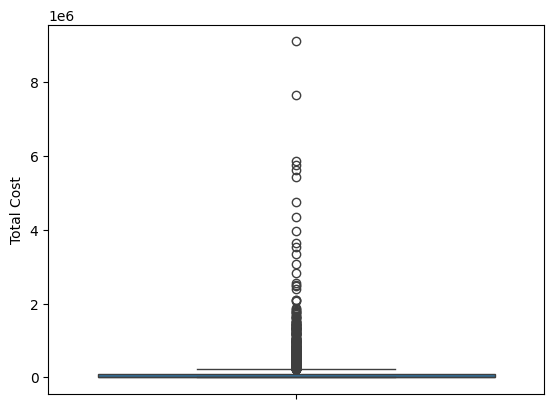

In [20]:
sns.boxplot(y_train)

In [21]:
X_train_processed

,# of Units,Total Weight in lbs,Food Product Category_Beef,Food Product Category_Beverages,Food Product Category_Butter,Food Product Category_Cheese,Food Product Category_Chicken,Food Product Category_Condiments & Snacks,Food Product Category_Eggs,Food Product Category_Fish (Wild),...,Food Product Category_Milk,Food Product Category_Milk & Dairy,Food Product Category_Non-Food,Food Product Category_Rice,Food Product Category_Roots & Tubers,Food Product Category_Seafood,Food Product Category_Tree Nuts & Seeds,"Food Product Category_Turkey, Other Poultry",Food Product Category_Vegetables,Food Product Category_Yogurt
0,18.0,432.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18610.0,502470.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42797.0,770346.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16470.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808,298266.0,298266.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2809,1.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2810,16145.0,242175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2811,76100.0,76100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_test_processed

,# of Units,Total Weight in lbs,Food Product Category_Beef,Food Product Category_Beverages,Food Product Category_Butter,Food Product Category_Cheese,Food Product Category_Chicken,Food Product Category_Condiments & Snacks,Food Product Category_Eggs,Food Product Category_Fish (Wild),...,Food Product Category_Milk,Food Product Category_Milk & Dairy,Food Product Category_Non-Food,Food Product Category_Rice,Food Product Category_Roots & Tubers,Food Product Category_Seafood,Food Product Category_Tree Nuts & Seeds,"Food Product Category_Turkey, Other Poultry",Food Product Category_Vegetables,Food Product Category_Yogurt
0,1642.0,39408.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1247.0,31175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,124306.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3805.0,68490.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,87.0,2610.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,74145.0,2669227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
934,4.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
935,116.0,116.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
936,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Fill NaN in y_train with the mean
y_train = y_train.fillna(y_train.mean())
# Step 5: Build a regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
model=lr.fit(X_train_processed,y_train)

In [24]:
# Fill NaN in y_test with the mean
y_test = y_test.fillna(y_test.mean())
# Evaluation Metric 1: R^2 score
from sklearn.metrics import r2_score
y_predicted = model.predict(X_test_processed)
r2_score(y_test, y_predicted)

0.6404908990345017

In [25]:
# Evaluation metric 2: MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_predicted)

37847495912.62251

In [26]:
# Make prediction for the new set of feature values (5, 15, 0, 0, 0, 1, 0, 0, 0, 0, 0)
# Prediciting the total cost of 5 units of Meals, weighing 15 lbs
model.predict(np.array([[5, 15, 0, 0, 0, 1, 0, 0, 0, 0, 0]]))

c:\Users\rahul\OneDrive\Documents\Desktop\CS301_Project_1\myvenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 11 features, but LinearRegression is expecting 25 features as input.